In [1]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import pandas as pd
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import control
import random

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

## Ejemplo 1

Dada una señal de entrada y salida, obtenga el modelo estimado usando el modelo ARMAX.

In [17]:
## Sistema de segundo orden en tiempo continuo
g = control.tf([20],[1,3,10,20])
dt = 0.05
t = np.linspace(0,25,1+int(25/dt))

# Señal de salida ideal "y"
_,y = control.step_response(g,t)
N = len(t)
u = np.ones(N)
## Ruido para simular la señal de salida capturada "yn"
r = 0
e = np.random.normal(0,1,size=N)
yn = y+e*r

gd = control.c2d(g,dt)
print(gd)

#a = np.asarray([t,yn])
#a = a.transpose()
#np.savetxt('data\clase_09.csv', a, delimiter=",")

data = {'t':t,'yn':yn,'un':u}

df = pd.DataFrame(data)
df.to_csv('data\clase_09.csv',index = False)


0.000401 z^2 + 0.001544 z + 0.000372
------------------------------------
 z^3 - 2.836 z^2 + 2.699 z - 0.8607

dt = 0.05



In [7]:
gd.pole()

array([0.96728408+0.16558021j, 0.96728408-0.16558021j,
       0.87106596+0.j        ])

,t,yn
0,0.000000,-0.046100
1,0.058561,-0.141515
2,0.117121,-0.012613
3,0.175682,0.001637
4,0.234243,0.036791
...,...,...
363,21.257524,1.004781
364,21.316085,0.939638
365,21.374646,1.186848
366,21.433206,0.962091


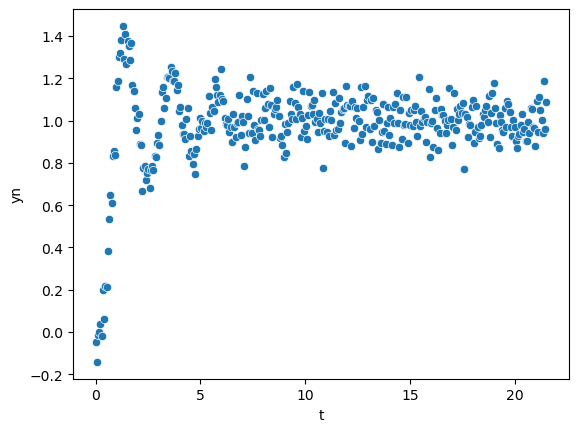

In [45]:
datos = pd.read_csv ('data\clase_09.csv')

sns.scatterplot(datos,x ='t',y = 'yn' )
datos

In [41]:
## Definir y_1, y_2, y_3, dependiendo el sistema que se quiera modelar
y_1 = np.zeros(N)
y_2 = np.zeros(N)
u_1 = np.zeros(N)

for k in range(1,N):
    y_1[k]=yn[k-1]
    u_1[k]=u[k-1]
for k in range(2,N):
    y_2[k]=yn[k-2]
    
## Creación del vector phi
phi = np.array([-y_1,-y_2,u_1]).transpose()

# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

alpha = 0.0
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([-0.14771062, -0.13538077,  0.48112161])

In [54]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)

## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 + theta[1]*z**-2  
B = theta[2]*z**-1 

## Calcular la función de transferencia G y H en simbólica
G = B/A
G = G.simplify()

H = 1/A
H = H.simplify()

## Definiendo las funciones del predictor:
## 1 - H^-1 = 1- A y H^-1*G = B

print('A continuación se observa el valor de 1-A y de B, para reconstruir')
_A = (1-A).simplify()
print(_A)
print(B)

A continuación se observa el valor de 1-A y de B, para reconstruir
(0.14771062132052*z + 0.135380766173951)/z**2
0.481121605714343/z


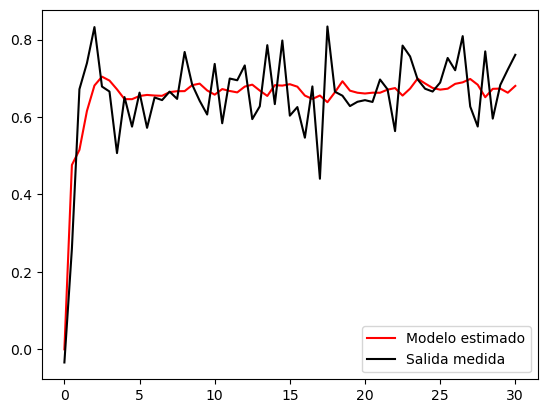

In [55]:
## Definiendo la función a estimar:

ye = -theta[0]*y_1-theta[1]*y_2+theta[2]*u_1
plt.plot(t,ye,color = 'red')
plt.plot(t,yn,color = 'black')
plt.legend(['Modelo estimado','Salida medida'])

In [56]:
ECM = np.sqrt(np.dot((yn-ye).transpose(),(yn-ye)))/len(yn)
print(ECM)

0.010958796696275051
